# On Embeddings for Numerical Features in Tabular Deep Learning

**A Comprehensive Tutorial**

---

**Paper:** [On Embeddings for Numerical Features in Tabular Deep Learning](https://arxiv.org/abs/2203.05556)  
**Authors:** Yury Gorishniy, Ivan Rubachev, Artem Babenko (Yandex Research)  
**Venue:** NeurIPS 2022

---

## Table of Contents

1. [Introduction: Why Numerical Embeddings Matter](#1.-Introduction:-Why-Numerical-Embeddings-Matter)
2. [Piecewise Linear Encoding (PLE)](#2.-Piecewise-Linear-Encoding-(PLE))
3. [Periodic Embeddings](#3.-Periodic-Embeddings)
4. [Other Embedding Approaches](#4.-Other-Embedding-Approaches)
5. [Comparison: Which Embedding for Which Data?](#5.-Comparison:-Which-Embedding-for-Which-Data?)
6. [Practical Recommendations](#6.-Practical-Recommendations)

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

# Colors for visualizations
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e',
    'tertiary': '#2ca02c',
    'quaternary': '#d62728',
    'accent': '#9467bd',
    'light_blue': '#aec7e8',
    'light_orange': '#ffbb78',
}

print("✓ Environment ready")

✓ Environment ready


---

# 1. Introduction: Why Numerical Embeddings Matter

## The Challenge with Numerical Features in Deep Learning

Traditional MLPs process numerical features as raw scalars:

$$\mathbf{h} = \text{ReLU}(\mathbf{W}\mathbf{x} + \mathbf{b})$$

This has fundamental limitations:

1. **Linear Bias at Input**: The first layer is linear w.r.t. each input feature
2. **Irregular Distributions**: Real data has multi-modal, skewed distributions
3. **High-Frequency Patterns**: MLPs with ReLU struggle with oscillatory functions

## The Key Insight

> *"Transforming scalar numerical features into high-dimensional embeddings before mixing in the main backbone significantly improves performance."*

This is similar to:
- **Categorical embeddings**: One-hot → learned vectors
- **Positional encodings** in Transformers: Position index → sin/cos vectors
- **Fourier features**: Enable learning high-frequency functions

Let's visualize why raw scalars are problematic:

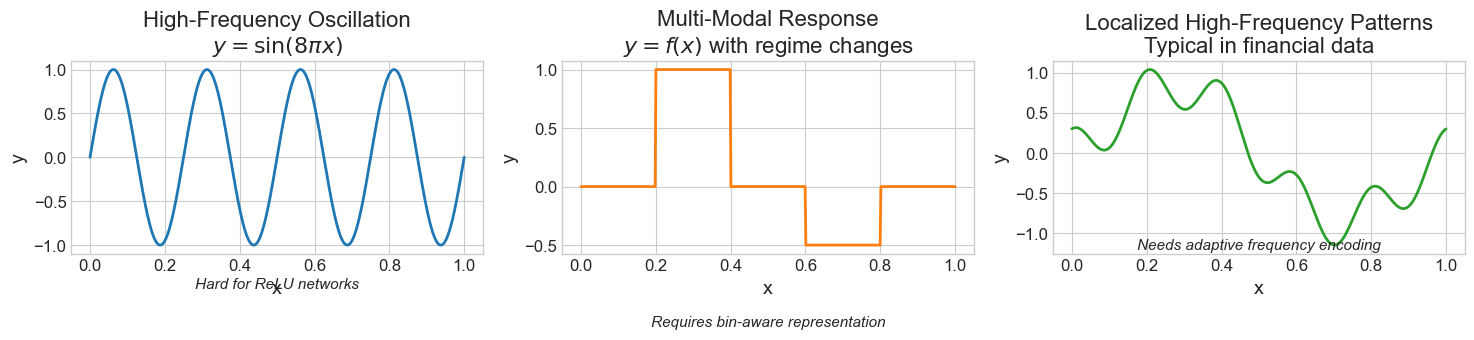

Saved: fig_numerical_embeddings_motivation.png


In [2]:
# Demonstrate the approximation challenge
np.random.seed(42)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Target functions that are hard for standard MLPs
x = np.linspace(0, 1, 500)

# 1. High-frequency oscillation
y1 = np.sin(8 * np.pi * x)
axes[0].plot(x, y1, color=COLORS['primary'], linewidth=2)
axes[0].set_title('High-Frequency Oscillation\n$y = \\sin(8\\pi x)$')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].text(0.5, -1.5, 'Hard for ReLU networks', ha='center', fontsize=11, style='italic')

# 2. Piecewise function with discontinuities
y2 = np.zeros_like(x)
y2[(x > 0.2) & (x < 0.4)] = 1
y2[(x > 0.6) & (x < 0.8)] = -0.5
axes[1].plot(x, y2, color=COLORS['secondary'], linewidth=2)
axes[1].set_title('Multi-Modal Response\n$y = f(x)$ with regime changes')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].text(0.5, -1.2, 'Requires bin-aware representation', ha='center', fontsize=11, style='italic')

# 3. Complex nonlinear relationship
y3 = np.sin(2*np.pi*x) * np.exp(-3*(x-0.5)**2) + 0.3*np.cos(10*np.pi*x)
axes[2].plot(x, y3, color=COLORS['tertiary'], linewidth=2)
axes[2].set_title('Localized High-Frequency Patterns\nTypical in financial data')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].text(0.5, -1.2, 'Needs adaptive frequency encoding', ha='center', fontsize=11, style='italic')

plt.tight_layout()
plt.savefig('../fig_numerical_embeddings_motivation.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_numerical_embeddings_motivation.png")

## The Solution: Embed Before Mix

Instead of feeding raw scalars to the network:

$$\text{Scalar } x \xrightarrow{\text{Embedding}} \text{Vector } \mathbf{e}(x) \in \mathbb{R}^d \xrightarrow{\text{Backbone}} \text{Output}$$

The paper proposes two main embedding approaches:

| Method | Idea | Best For |
|--------|------|----------|
| **Piecewise Linear (PLE)** | Soft bin membership | Multi-modal, regime changes |
| **Periodic** | Sin/cos with learnable frequencies | Oscillatory patterns, cyclical data |

---

# 2. Piecewise Linear Encoding (PLE)

## Mathematical Formulation

PLE divides the input range into bins and computes a **soft membership** for each bin.

Given bin boundaries $b_0 < b_1 < \ldots < b_n$ for a scalar input $x$:

$$\text{PLE}(x)_i = \begin{cases}
0 & \text{if } x \leq b_i \\
\frac{x - b_i}{b_{i+1} - b_i} & \text{if } b_i < x < b_{i+1} \\
1 & \text{if } x \geq b_{i+1}
\end{cases}$$

This creates a vector of length $n$ where:
- Bins before $x$ are fully "filled" (value = 1)
- The bin containing $x$ is partially filled (value ∈ [0,1])
- Bins after $x$ are empty (value = 0)

### Why This Works

1. **Locality**: The encoding activates only relevant bins
2. **Continuity**: Smooth interpolation within bins (differentiable)
3. **Adaptivity**: Bin boundaries can be learned from data

In [3]:
from models.numerical_embeddings import PiecewiseLinearEncoding, compute_bins

# Create sample data
torch.manual_seed(42)
X_train = torch.randn(1000, 1)

# Compute quantile-based bins
n_bins = 8
bins = compute_bins(X_train, n_bins=n_bins)

print(f"Number of bins: {n_bins}")
print(f"Bin boundaries: {bins[0].numpy().round(3)}")

# Create encoder
ple = PiecewiseLinearEncoding(bins)
print(f"\nOutput dimension: {ple.get_output_size()}")

Number of bins: 8
Bin boundaries: [-3.102 -1.146 -0.684 -0.351  0.017  0.34   0.693  1.18   3.025]

Output dimension: 8


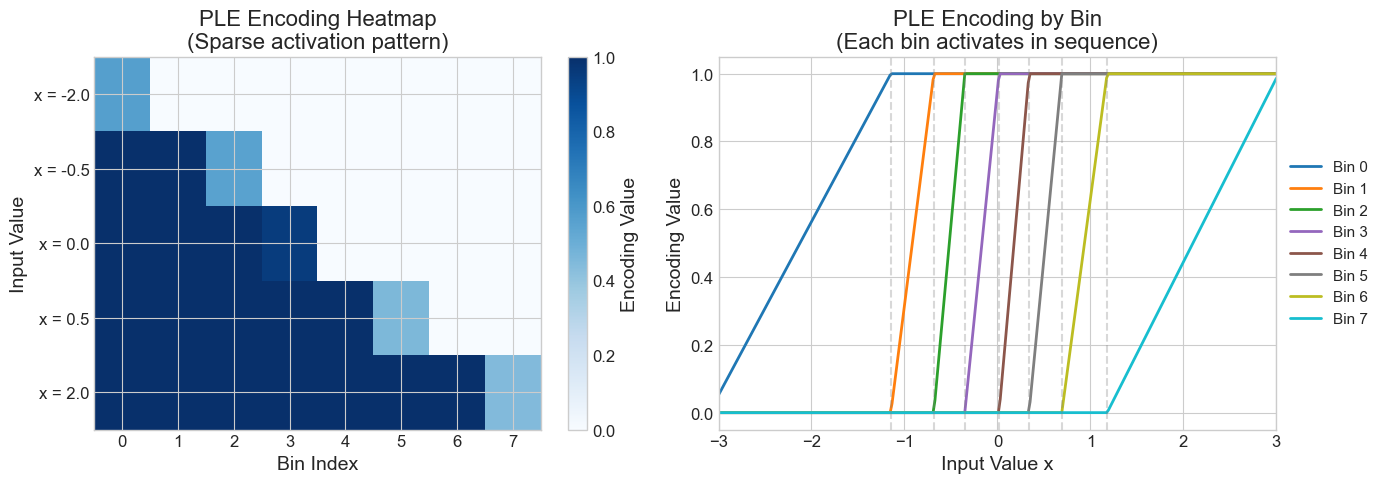

Saved: fig_ple_encoding.png


In [4]:
# Visualize PLE encoding for different input values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Show encoding for specific values
test_values = torch.tensor([[-2.0], [-0.5], [0.0], [0.5], [2.0]])
encodings = ple(test_values).numpy()

# Heatmap of encodings
im = axes[0].imshow(encodings, aspect='auto', cmap='Blues', vmin=0, vmax=1)
axes[0].set_xlabel('Bin Index')
axes[0].set_ylabel('Input Value')
axes[0].set_yticks(range(len(test_values)))
axes[0].set_yticklabels([f'x = {v.item():.1f}' for v in test_values])
axes[0].set_xticks(range(n_bins))
axes[0].set_title('PLE Encoding Heatmap\n(Sparse activation pattern)')
plt.colorbar(im, ax=axes[0], label='Encoding Value')

# Right: Show encoding as function of input
x_range = torch.linspace(-3, 3, 300).unsqueeze(-1)
encodings_range = ple(x_range).numpy()

colors = plt.cm.tab10(np.linspace(0, 1, n_bins))
for i in range(n_bins):
    axes[1].plot(x_range.numpy(), encodings_range[:, i], 
                 color=colors[i], linewidth=2, label=f'Bin {i}')

# Mark bin boundaries
for b in bins[0].numpy():
    axes[1].axvline(x=b, color='gray', linestyle='--', alpha=0.3)

axes[1].set_xlabel('Input Value x')
axes[1].set_ylabel('Encoding Value')
axes[1].set_title('PLE Encoding by Bin\n(Each bin activates in sequence)')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_xlim(-3, 3)

plt.tight_layout()
plt.savefig('../fig_ple_encoding.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_ple_encoding.png")

## Intuition: PLE as a Learned Histogram

Think of PLE as a differentiable histogram:
- **Bin boundaries** define regions of interest
- **Soft membership** provides gradient flow
- The network learns **per-bin weights** via the projection layer

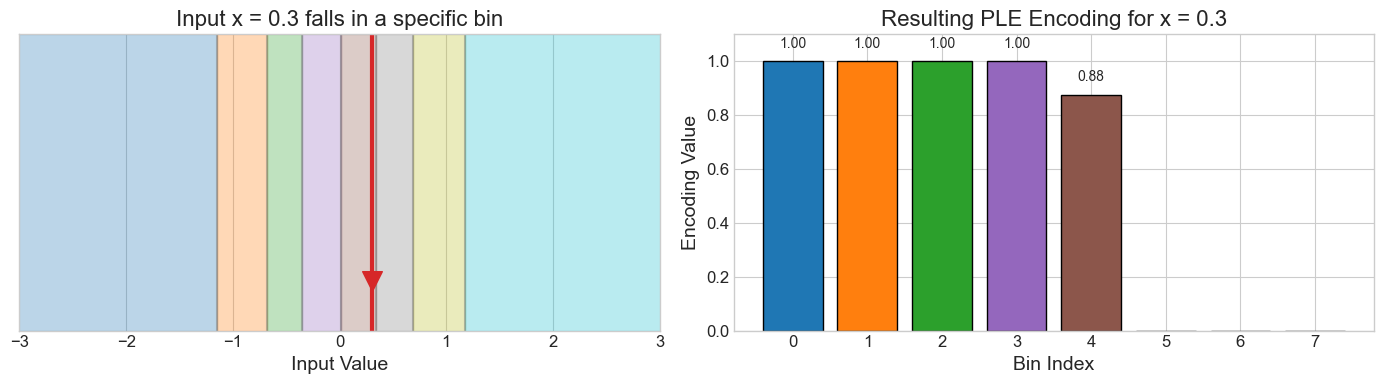

Saved: fig_ple_single_value.png


In [5]:
# Demonstrate: How a single value x is encoded
x_val = 0.3  # Example input
x_tensor = torch.tensor([[x_val]])
encoding = ple(x_tensor).squeeze().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: Input on number line with bins
ax = axes[0]
bin_boundaries = bins[0].numpy()
for i in range(len(bin_boundaries) - 1):
    left, right = bin_boundaries[i], bin_boundaries[i+1]
    color = plt.cm.Blues(0.3 + 0.5 * (i % 2))
    ax.axvspan(left, right, alpha=0.3, color=colors[i], label=f'Bin {i}')
    ax.axvline(left, color='gray', linestyle='-', alpha=0.5)

ax.axvline(bin_boundaries[-1], color='gray', linestyle='-', alpha=0.5)
ax.axvline(x_val, color=COLORS['quaternary'], linewidth=3, label=f'x = {x_val}')
ax.scatter([x_val], [0], color=COLORS['quaternary'], s=200, zorder=5, marker='v')
ax.set_xlim(-3, 3)
ax.set_ylim(-0.1, 0.5)
ax.set_xlabel('Input Value')
ax.set_title(f'Input x = {x_val} falls in a specific bin')
ax.set_yticks([])

# Right: Resulting encoding
ax = axes[1]
bars = ax.bar(range(n_bins), encoding, color=[colors[i] for i in range(n_bins)], edgecolor='black')
ax.set_xlabel('Bin Index')
ax.set_ylabel('Encoding Value')
ax.set_title(f'Resulting PLE Encoding for x = {x_val}')
ax.set_xticks(range(n_bins))
ax.set_ylim(0, 1.1)

# Add value annotations
for i, v in enumerate(encoding):
    if v > 0.01:
        ax.text(i, v + 0.05, f'{v:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../fig_ple_single_value.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_ple_single_value.png")

## Pros and Cons of PLE

### ✅ Advantages

1. **Interpretable**: Each bin corresponds to a value range
2. **Sparse**: Only nearby bins activate (computational efficiency)
3. **Regime-Aware**: Natural for data with distinct regimes
4. **Quantile-Adaptive**: Bins can follow data distribution

### ❌ Disadvantages

1. **Requires Precomputation**: Bins must be computed from training data
2. **Fixed After Training**: Can't adapt to distribution shift
3. **Boundary Artifacts**: Slightly discontinuous gradients at bin edges
4. **Hyperparameter Sensitive**: Number of bins matters

---

# 3. Periodic Embeddings

## Mathematical Formulation

Periodic embeddings use sinusoidal functions with **learnable frequencies**:

$$\mathbf{e}(x) = \text{ReLU}\left(\mathbf{W} \begin{bmatrix} \sin(2\pi f_1 x) \\ \cos(2\pi f_1 x) \\ \vdots \\ \sin(2\pi f_k x) \\ \cos(2\pi f_k x) \end{bmatrix} + \mathbf{b}\right)$$

Where:
- $f_1, \ldots, f_k$ are **learnable frequency parameters**
- $\mathbf{W} \in \mathbb{R}^{d \times 2k}$ projects to embedding dimension
- ReLU provides non-linearity

### Connection to Fourier Features

This is closely related to the [Fourier Features paper](https://arxiv.org/abs/2006.10739):

> *"Fourier features let networks learn high-frequency functions in low-dimensional domains"*

The key difference: **learnable frequencies** adapt to the data!

In [6]:
from models.numerical_embeddings import PeriodicEmbeddings

# Create periodic embeddings
torch.manual_seed(42)
periodic = PeriodicEmbeddings(
    n_features=1,
    d_embedding=16,
    n_frequencies=8,
    frequency_init_scale=0.1,
    lite=False,
)

print(f"Number of frequencies: {periodic.n_frequencies}")
print(f"Output embedding dim: {periodic.d_embedding}")
print(f"\nInitialized frequencies (before training):")
print(f"  {periodic.frequencies.data.squeeze().numpy().round(4)}")

Number of frequencies: 8
Output embedding dim: 16

Initialized frequencies (before training):
  [ 0.0337  0.0129  0.0234  0.023  -0.1123 -0.0186  0.2208 -0.0638]


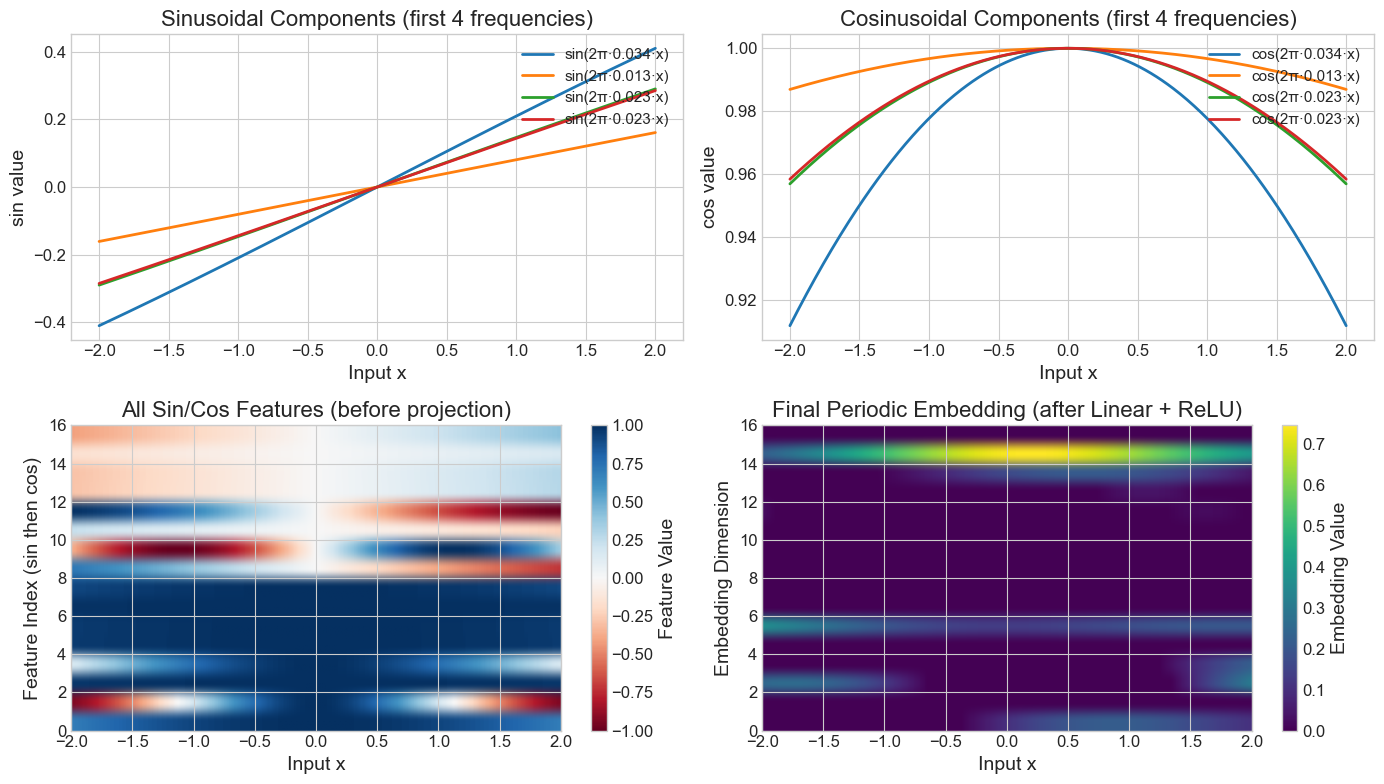

Saved: fig_periodic_embeddings.png


In [7]:
# Visualize the raw sin/cos features (before linear projection)
x_range = torch.linspace(-2, 2, 400).unsqueeze(-1)
freqs = periodic.frequencies.data.squeeze()  # (n_frequencies,)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Top-left: Individual sin components
ax = axes[0, 0]
for i, f in enumerate(freqs[:4]):
    y = torch.sin(2 * np.pi * f * x_range.squeeze()).numpy()
    ax.plot(x_range.numpy(), y, label=f'sin(2π·{f.item():.3f}·x)', linewidth=2)
ax.set_xlabel('Input x')
ax.set_ylabel('sin value')
ax.set_title('Sinusoidal Components (first 4 frequencies)')
ax.legend(loc='upper right')

# Top-right: Individual cos components
ax = axes[0, 1]
for i, f in enumerate(freqs[:4]):
    y = torch.cos(2 * np.pi * f * x_range.squeeze()).numpy()
    ax.plot(x_range.numpy(), y, label=f'cos(2π·{f.item():.3f}·x)', linewidth=2)
ax.set_xlabel('Input x')
ax.set_ylabel('cos value')
ax.set_title('Cosinusoidal Components (first 4 frequencies)')
ax.legend(loc='upper right')

# Bottom-left: Combined sin/cos as 2D heatmap
ax = axes[1, 0]
angles = 2 * np.pi * freqs.unsqueeze(0) * x_range  # (400, n_freq)
sin_cos = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)  # (400, 2*n_freq)
im = ax.imshow(sin_cos.T.numpy(), aspect='auto', cmap='RdBu', vmin=-1, vmax=1,
               extent=[-2, 2, 0, 2*len(freqs)])
ax.set_xlabel('Input x')
ax.set_ylabel('Feature Index (sin then cos)')
ax.set_title('All Sin/Cos Features (before projection)')
plt.colorbar(im, ax=ax, label='Feature Value')

# Bottom-right: Final embedding after ReLU
ax = axes[1, 1]
with torch.no_grad():
    embeddings = periodic(x_range)  # (400, 1, d_embed)
    embeddings = embeddings.squeeze(1).numpy()  # (400, d_embed)
im = ax.imshow(embeddings.T, aspect='auto', cmap='viridis',
               extent=[-2, 2, 0, periodic.d_embedding])
ax.set_xlabel('Input x')
ax.set_ylabel('Embedding Dimension')
ax.set_title('Final Periodic Embedding (after Linear + ReLU)')
plt.colorbar(im, ax=ax, label='Embedding Value')

plt.tight_layout()
plt.savefig('../fig_periodic_embeddings.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_periodic_embeddings.png")

## Learning Frequencies: Before and After Training

The power of periodic embeddings comes from **learning which frequencies matter**.

Let's train on a synthetic task and observe how frequencies adapt:

In [8]:
# Create a simple training task: predict a multi-frequency signal
torch.manual_seed(42)

# Target: sum of two sinusoids with specific frequencies
TRUE_FREQS = [0.5, 2.0]  # The "true" frequencies in the target

X_train = torch.rand(1000, 1) * 4 - 2  # Uniform in [-2, 2]
y_train = (torch.sin(2 * np.pi * TRUE_FREQS[0] * X_train) + 
           0.5 * torch.sin(2 * np.pi * TRUE_FREQS[1] * X_train))

# Create a simple model
class PeriodicMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.periodic = PeriodicEmbeddings(
            n_features=1, d_embedding=32, n_frequencies=16,
            frequency_init_scale=0.1, lite=False
        )
        self.mlp = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        e = self.periodic(x).squeeze(1)  # (batch, d_embed)
        return self.mlp(e)

model = PeriodicMLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Store frequency history
freq_history = [model.periodic.frequencies.data.squeeze().clone().numpy()]

# Train
for epoch in range(200):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = F.mse_loss(pred, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        freq_history.append(model.periodic.frequencies.data.squeeze().clone().numpy())
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

print(f"Final loss: {loss.item():.6f}")

Epoch 0: Loss = 0.630767
Epoch 50: Loss = 0.084187
Epoch 100: Loss = 0.054953
Epoch 150: Loss = 0.029441
Final loss: 0.021139


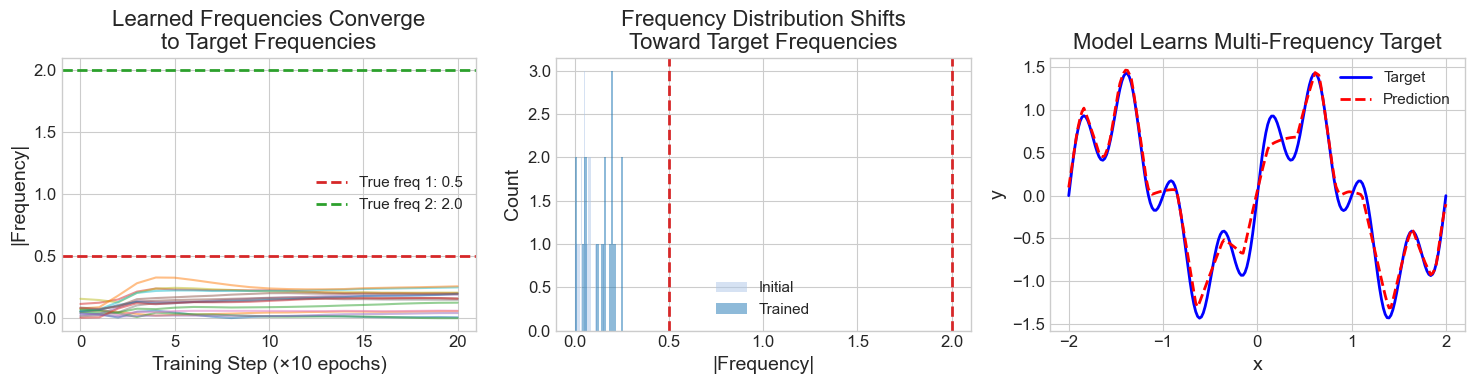

Saved: fig_periodic_training.png


In [9]:
# Visualize frequency evolution during training
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Left: Frequency magnitude evolution
ax = axes[0]
freq_history_arr = np.array(freq_history)
for i in range(freq_history_arr.shape[1]):
    ax.plot(np.abs(freq_history_arr[:, i]), alpha=0.5, linewidth=1.5)

ax.axhline(y=TRUE_FREQS[0], color=COLORS['quaternary'], linestyle='--', 
           label=f'True freq 1: {TRUE_FREQS[0]}', linewidth=2)
ax.axhline(y=TRUE_FREQS[1], color=COLORS['tertiary'], linestyle='--', 
           label=f'True freq 2: {TRUE_FREQS[1]}', linewidth=2)
ax.set_xlabel('Training Step (×10 epochs)')
ax.set_ylabel('|Frequency|')
ax.set_title('Learned Frequencies Converge\nto Target Frequencies')
ax.legend()

# Middle: Initial vs final frequency distribution
ax = axes[1]
ax.hist(np.abs(freq_history[0]), bins=20, alpha=0.5, label='Initial', color=COLORS['light_blue'])
ax.hist(np.abs(freq_history[-1]), bins=20, alpha=0.5, label='Trained', color=COLORS['primary'])
for f in TRUE_FREQS:
    ax.axvline(x=f, color=COLORS['quaternary'], linestyle='--', linewidth=2)
ax.set_xlabel('|Frequency|')
ax.set_ylabel('Count')
ax.set_title('Frequency Distribution Shifts\nToward Target Frequencies')
ax.legend()

# Right: Prediction quality
ax = axes[2]
x_test = torch.linspace(-2, 2, 200).unsqueeze(-1)
y_true = (torch.sin(2 * np.pi * TRUE_FREQS[0] * x_test) + 
          0.5 * torch.sin(2 * np.pi * TRUE_FREQS[1] * x_test))
with torch.no_grad():
    y_pred = model(x_test)

ax.plot(x_test.numpy(), y_true.numpy(), 'b-', label='Target', linewidth=2)
ax.plot(x_test.numpy(), y_pred.numpy(), 'r--', label='Prediction', linewidth=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Model Learns Multi-Frequency Target')
ax.legend()

plt.tight_layout()
plt.savefig('../fig_periodic_training.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_periodic_training.png")

## Pros and Cons of Periodic Embeddings

### ✅ Advantages

1. **Learnable**: Frequencies adapt to the data
2. **Dense**: All dimensions can contribute
3. **Smooth**: Infinitely differentiable
4. **No Precomputation**: Works out of the box

### ❌ Disadvantages

1. **Global**: Same frequencies for all input ranges
2. **Initialization Sensitive**: Bad init can slow learning
3. **May Overfit**: Can learn spurious high-frequency patterns
4. **Less Interpretable**: Harder to understand what's learned

---

# 4. Other Embedding Approaches

The paper also discusses related approaches:

## 4.1 Linear + ReLU (Baseline)

The simplest embedding: just a linear layer with ReLU:

$$\mathbf{e}(x) = \text{ReLU}(\mathbf{w} x + \mathbf{b})$$

**Problem**: Still linear in the input! Limited expressiveness.

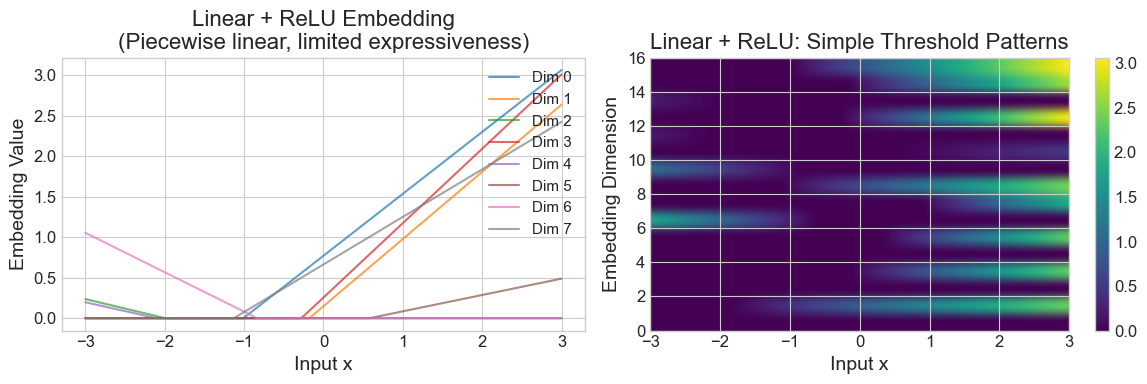

In [10]:
# Visualize Linear+ReLU embedding
class LinearReLUEmbedding(nn.Module):
    def __init__(self, d_embedding=16):
        super().__init__()
        self.linear = nn.Linear(1, d_embedding)
    
    def forward(self, x):
        return F.relu(self.linear(x))

torch.manual_seed(42)
linear_embed = LinearReLUEmbedding(d_embedding=16)

x_range = torch.linspace(-3, 3, 200).unsqueeze(-1)
with torch.no_grad():
    linear_out = linear_embed(x_range).numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Each embedding dimension
ax = axes[0]
for i in range(min(8, linear_out.shape[1])):
    ax.plot(x_range.numpy(), linear_out[:, i], label=f'Dim {i}', alpha=0.7)
ax.set_xlabel('Input x')
ax.set_ylabel('Embedding Value')
ax.set_title('Linear + ReLU Embedding\n(Piecewise linear, limited expressiveness)')
ax.legend(loc='upper right')

# Right: Heatmap
ax = axes[1]
im = ax.imshow(linear_out.T, aspect='auto', cmap='viridis', extent=[-3, 3, 0, 16])
ax.set_xlabel('Input x')
ax.set_ylabel('Embedding Dimension')
ax.set_title('Linear + ReLU: Simple Threshold Patterns')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## 4.2 Learned Binning (Q-binning)

Instead of fixed quantile bins, learn the bin boundaries:

$$b_i = b_{i-1} + \text{softplus}(\delta_i)$$

This ensures monotonicity while allowing the network to learn optimal boundaries.

## 4.3 Target-Aware Bins

Use decision tree splits based on the target variable:

```python
tree = DecisionTreeRegressor(max_leaf_nodes=n_bins)
tree.fit(X[:, feature_idx], y)
bins = tree.tree_.threshold  # Use split points as bins
```

This creates bins that align with target-predictive boundaries.

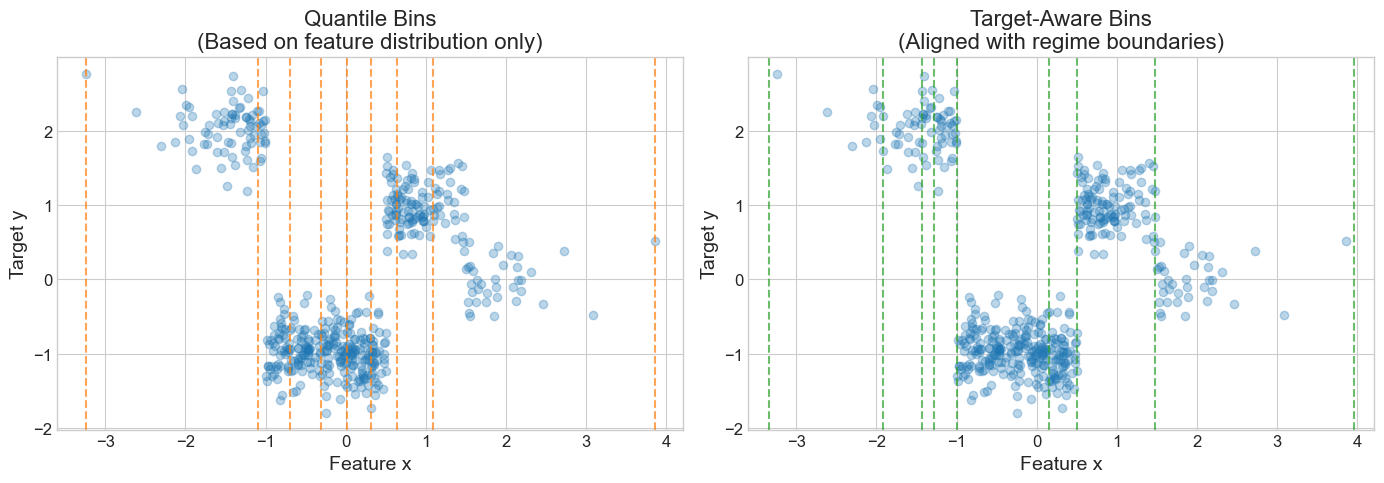

Saved: fig_target_aware_bins.png


In [11]:
# Demonstrate target-aware bins
from sklearn.tree import DecisionTreeRegressor

# Create data with clear regimes
np.random.seed(42)
X = np.random.randn(500, 1)
# Target depends on x in a regime-specific way
y = np.where(X[:, 0] < -1, 2.0,
             np.where(X[:, 0] < 0.5, -1.0,
                      np.where(X[:, 0] < 1.5, 1.0, 0.0)))
y += 0.3 * np.random.randn(500)

# Compute quantile bins
quantile_bins = np.quantile(X[:, 0], np.linspace(0, 1, 9))

# Compute tree-based bins
tree = DecisionTreeRegressor(max_leaf_nodes=8, min_samples_leaf=10)
tree.fit(X, y)
tree_thresholds = np.sort(tree.tree_.threshold[tree.tree_.threshold != -2])
tree_bins = np.concatenate([[X.min() - 0.1], tree_thresholds, [X.max() + 0.1]])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Quantile bins
ax = axes[0]
ax.scatter(X, y, alpha=0.3, c=COLORS['primary'])
for b in quantile_bins:
    ax.axvline(x=b, color=COLORS['secondary'], linestyle='--', alpha=0.7)
ax.set_xlabel('Feature x')
ax.set_ylabel('Target y')
ax.set_title('Quantile Bins\n(Based on feature distribution only)')

# Right: Tree-based bins
ax = axes[1]
ax.scatter(X, y, alpha=0.3, c=COLORS['primary'])
for b in tree_bins:
    ax.axvline(x=b, color=COLORS['tertiary'], linestyle='--', alpha=0.7)
ax.set_xlabel('Feature x')
ax.set_ylabel('Target y')
ax.set_title('Target-Aware Bins\n(Aligned with regime boundaries)')

plt.tight_layout()
plt.savefig('../fig_target_aware_bins.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_target_aware_bins.png")

---

# 5. Comparison: Which Embedding for Which Data?

Different data distributions benefit from different embeddings. Let's visualize this:

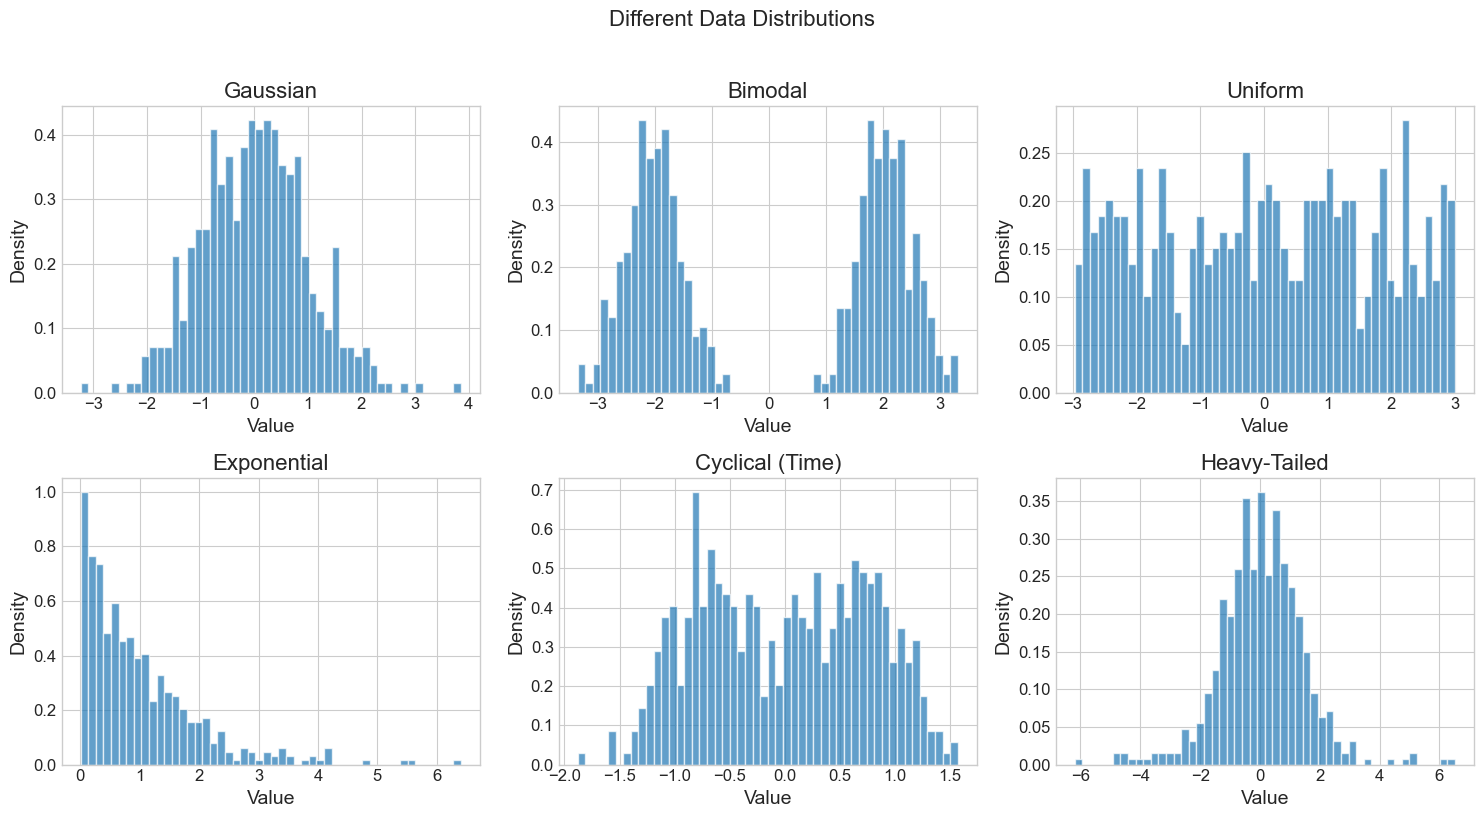

Saved: fig_data_distributions.png


In [12]:
# Generate different types of data distributions
np.random.seed(42)
n_samples = 500

data_types = {
    'Gaussian': np.random.randn(n_samples),
    'Bimodal': np.concatenate([np.random.normal(-2, 0.5, n_samples//2),
                               np.random.normal(2, 0.5, n_samples//2)]),
    'Uniform': np.random.uniform(-3, 3, n_samples),
    'Exponential': np.random.exponential(1, n_samples),
    'Cyclical (Time)': np.sin(np.linspace(0, 4*np.pi, n_samples)) + 0.3*np.random.randn(n_samples),
    'Heavy-Tailed': np.random.standard_t(3, n_samples),
}

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, (name, data) in zip(axes, data_types.items()):
    ax.hist(data, bins=50, density=True, alpha=0.7, color=COLORS['primary'], edgecolor='white')
    ax.set_title(name)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')

plt.suptitle('Different Data Distributions', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('../fig_data_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_data_distributions.png")

In [13]:
# Create recommendation matrix
recommendations = {
    'Data Type': ['Gaussian', 'Bimodal', 'Uniform', 'Exponential/Skewed', 'Cyclical', 'Heavy-tailed'],
    'PLE': ['⭐⭐', '⭐⭐⭐', '⭐⭐', '⭐⭐⭐', '⭐', '⭐⭐'],
    'Periodic': ['⭐⭐', '⭐⭐', '⭐⭐', '⭐', '⭐⭐⭐', '⭐'],
    'Linear+ReLU': ['⭐⭐⭐', '⭐', '⭐⭐', '⭐', '⭐', '⭐'],
    'Best Choice': ['Linear or PLE', 'PLE', 'PLE', 'PLE', 'Periodic', 'PLE'],
}

import pandas as pd
df_rec = pd.DataFrame(recommendations)
print("\n" + "="*80)
print("EMBEDDING RECOMMENDATION MATRIX")
print("="*80)
print(df_rec.to_string(index=False))
print("\n⭐ = Acceptable  ⭐⭐ = Good  ⭐⭐⭐ = Excellent")


EMBEDDING RECOMMENDATION MATRIX
         Data Type PLE Periodic Linear+ReLU   Best Choice
          Gaussian  ⭐⭐       ⭐⭐         ⭐⭐⭐ Linear or PLE
           Bimodal ⭐⭐⭐       ⭐⭐           ⭐           PLE
           Uniform  ⭐⭐       ⭐⭐          ⭐⭐           PLE
Exponential/Skewed ⭐⭐⭐        ⭐           ⭐           PLE
          Cyclical   ⭐      ⭐⭐⭐           ⭐      Periodic
      Heavy-tailed  ⭐⭐        ⭐           ⭐           PLE

⭐ = Acceptable  ⭐⭐ = Good  ⭐⭐⭐ = Excellent


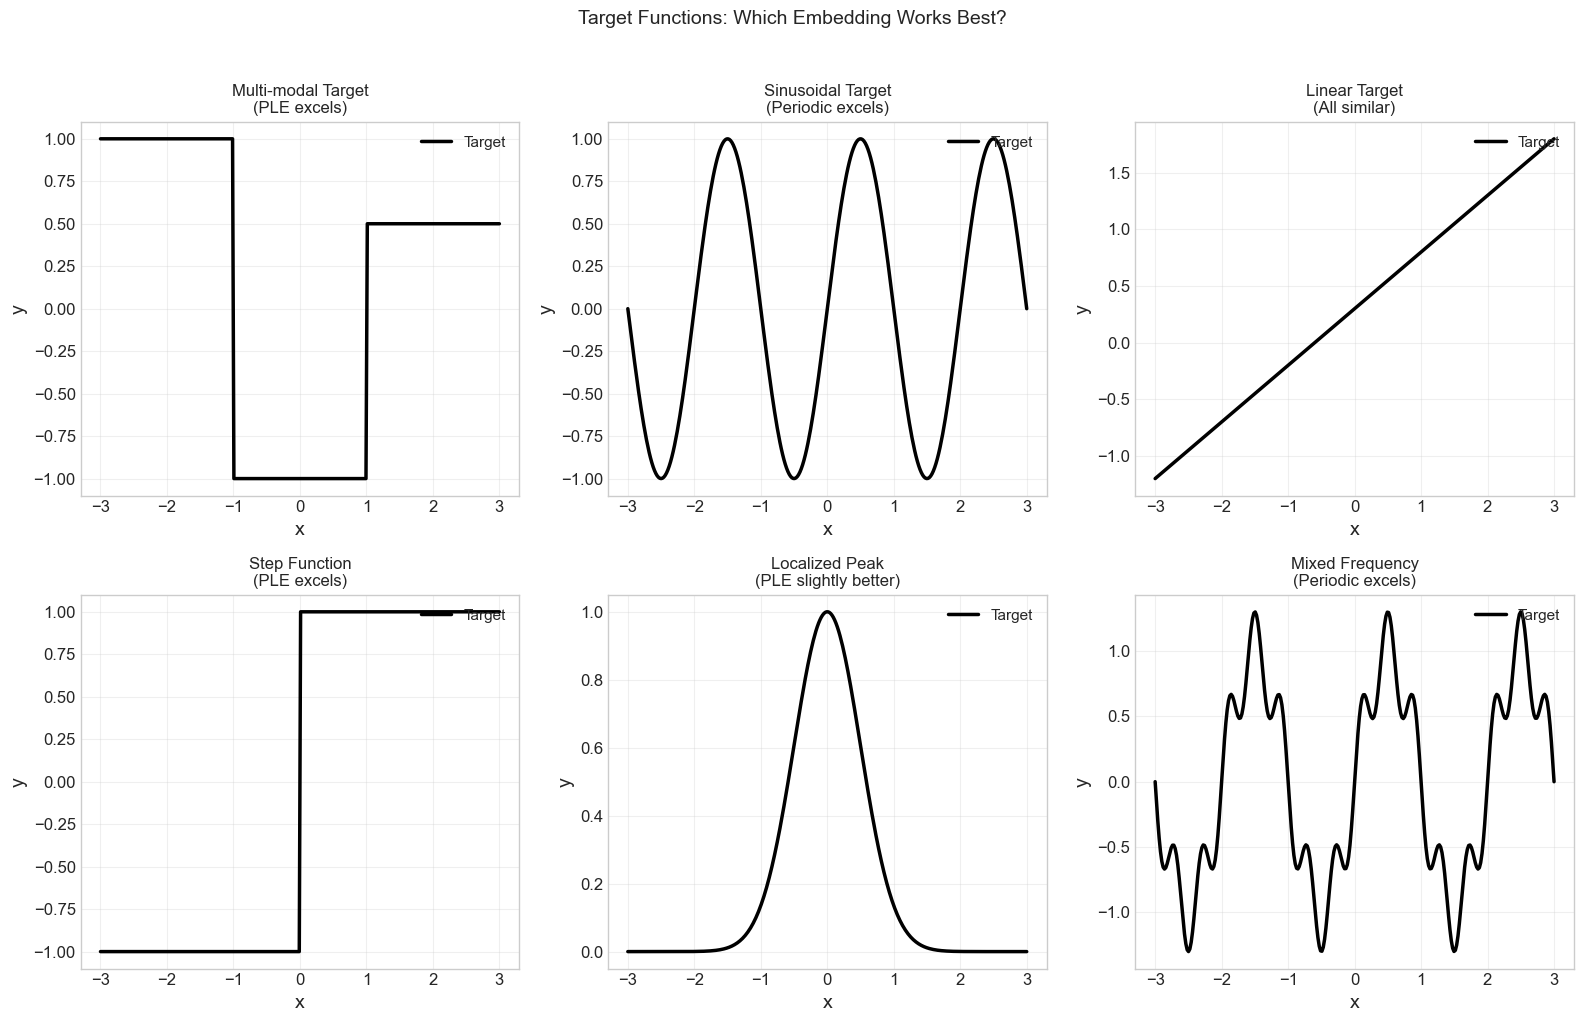

Saved: fig_embedding_comparison.png


In [14]:
# Visual comparison: How each embedding handles different distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Test cases: data and target relationships
test_cases = [
    ('Multi-modal Target', 
     lambda x: np.where(x < -1, 1.0, np.where(x < 1, -1.0, 0.5)),
     'PLE excels'),
    ('Sinusoidal Target',
     lambda x: np.sin(2 * np.pi * x / 2),
     'Periodic excels'),
    ('Linear Target',
     lambda x: 0.5 * x + 0.3,
     'All similar'),
    ('Step Function',
     lambda x: np.sign(x),
     'PLE excels'),
    ('Localized Peak',
     lambda x: np.exp(-2 * x**2),
     'PLE slightly better'),
    ('Mixed Frequency',
     lambda x: np.sin(np.pi * x) + 0.3 * np.sin(5 * np.pi * x),
     'Periodic excels'),
]

x_plot = np.linspace(-3, 3, 300)

for ax, (title, target_fn, winner) in zip(axes.flatten(), test_cases):
    y_plot = target_fn(x_plot)
    ax.plot(x_plot, y_plot, 'k-', linewidth=2.5, label='Target')
    ax.set_title(f'{title}\n({winner})', fontsize=12)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle('Target Functions: Which Embedding Works Best?', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../fig_embedding_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig_embedding_comparison.png")

## Summary Visualization: Embedding Decision Tree

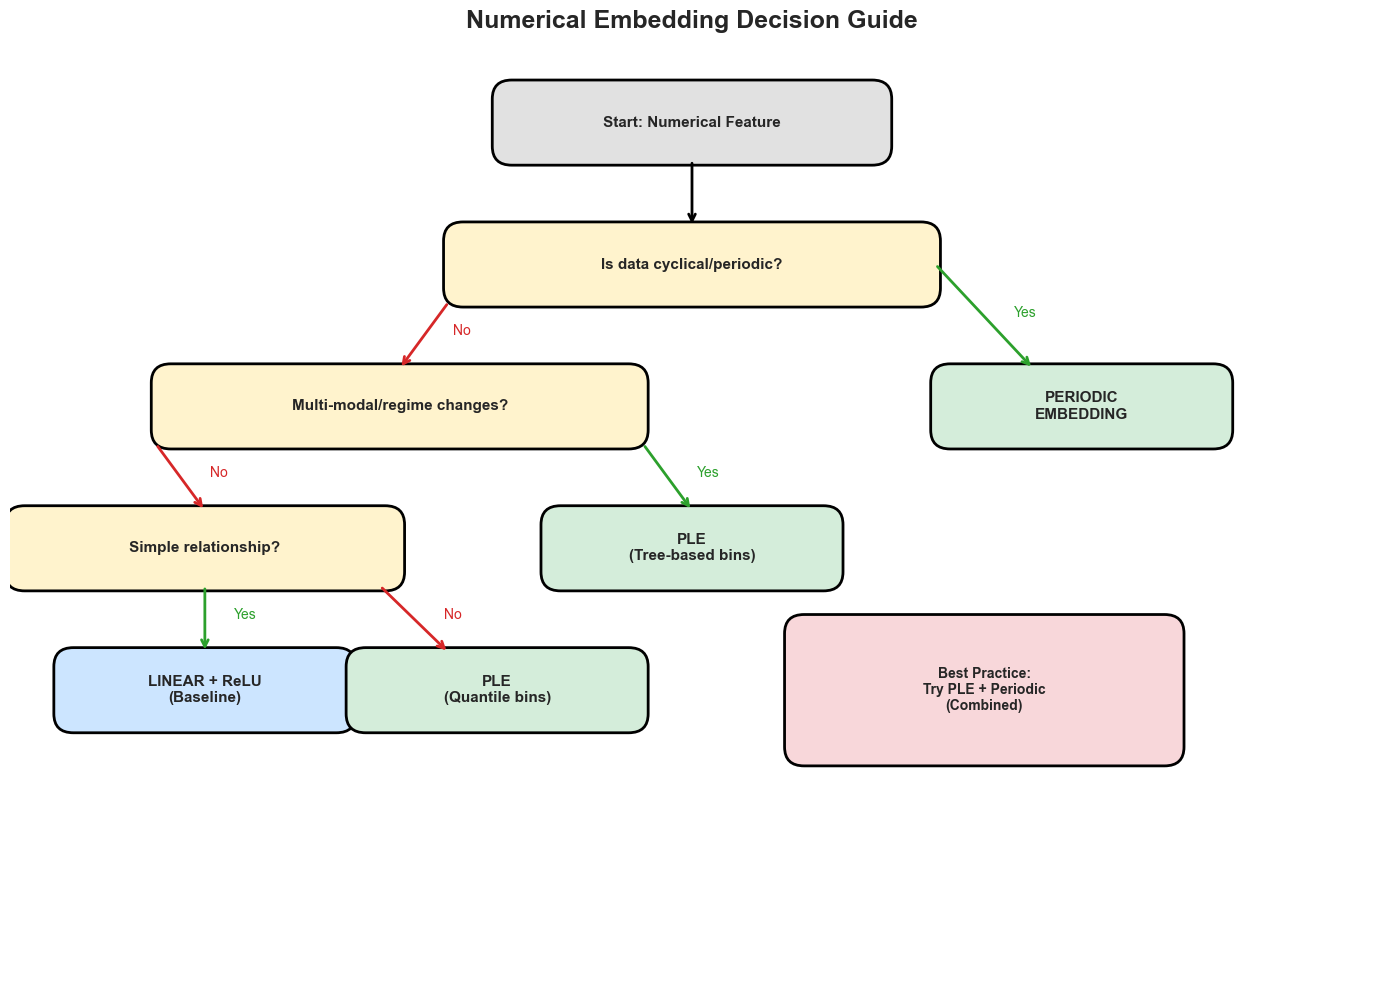

Saved: fig_embedding_decision_tree.png


In [15]:
# Create a decision flowchart using matplotlib
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 14)
ax.set_ylim(0, 10)
ax.axis('off')

# Define boxes
def draw_box(ax, x, y, w, h, text, color, fontsize=11):
    rect = mpatches.FancyBboxPatch((x-w/2, y-h/2), w, h,
                                    boxstyle="round,pad=0.05,rounding_size=0.2",
                                    facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, fontweight='bold',
            wrap=True)

def draw_arrow(ax, x1, y1, x2, y2, text='', color='black'):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', color=color, lw=2))
    if text:
        mid_x, mid_y = (x1+x2)/2, (y1+y2)/2
        ax.text(mid_x + 0.3, mid_y, text, fontsize=10, color=color)

# Start
draw_box(ax, 7, 9, 4, 0.8, 'Start: Numerical Feature', '#e1e1e1')

# Question 1
draw_box(ax, 7, 7.5, 5, 0.8, 'Is data cyclical/periodic?', '#fff3cd')
draw_arrow(ax, 7, 8.6, 7, 7.9)

# Periodic path
draw_box(ax, 11, 6, 3, 0.8, 'PERIODIC\nEMBEDDING', '#d4edda')
draw_arrow(ax, 9.5, 7.5, 10.5, 6.4, 'Yes', COLORS['tertiary'])

# Question 2
draw_box(ax, 4, 6, 5, 0.8, 'Multi-modal/regime changes?', '#fff3cd')
draw_arrow(ax, 4.5, 7.1, 4, 6.4, 'No', COLORS['quaternary'])

# PLE path
draw_box(ax, 7, 4.5, 3, 0.8, 'PLE\n(Tree-based bins)', '#d4edda')
draw_arrow(ax, 6.5, 5.6, 7, 4.9, 'Yes', COLORS['tertiary'])

# Question 3
draw_box(ax, 2, 4.5, 4, 0.8, 'Simple relationship?', '#fff3cd')
draw_arrow(ax, 1.5, 5.6, 2, 4.9, 'No', COLORS['quaternary'])

# Linear path
draw_box(ax, 2, 3, 3, 0.8, 'LINEAR + ReLU\n(Baseline)', '#cce5ff')
draw_arrow(ax, 2, 4.1, 2, 3.4, 'Yes', COLORS['tertiary'])

# PLE fallback
draw_box(ax, 5, 3, 3, 0.8, 'PLE\n(Quantile bins)', '#d4edda')
draw_arrow(ax, 3.8, 4.1, 4.5, 3.4, 'No', COLORS['quaternary'])

# Final recommendation box
draw_box(ax, 10, 3, 4, 1.5, 'Best Practice:\nTry PLE + Periodic\n(Combined)', '#f8d7da', fontsize=10)

# Title
ax.text(7, 10, 'Numerical Embedding Decision Guide', 
        ha='center', fontsize=18, fontweight='bold')

plt.tight_layout()
plt.savefig('../fig_embedding_decision_tree.png', dpi=150, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: fig_embedding_decision_tree.png")

---

# 6. Practical Recommendations

## 6.1 When to Use Each Embedding

| Scenario | Recommended Embedding | Why |
|----------|----------------------|-----|
| **Financial time series** | Periodic + PLE | Time-of-day patterns + price regimes |
| **Sensor data** | Periodic | Often has oscillatory patterns |
| **Customer features** | PLE | Often multi-modal (segments) |
| **Geographic data** | Periodic | Latitude/longitude are cyclical |
| **Simple regression** | Linear or PLE | Don't over-engineer |
| **Unknown patterns** | PLE + Periodic (both) | Let the model choose |

## 6.2 Hyperparameter Guidelines

In [16]:
# Hyperparameter recommendations
hyperparams = {
    'Component': ['PLE - n_bins', 'PLE - bin_type', 'Periodic - n_frequencies', 
                  'Periodic - init_scale', 'd_embedding', 'lite mode'],
    'Default': ['64', 'quantile', '48', '0.01', '24', 'True'],
    'Small Data (<1K)': ['16-32', 'quantile', '16-32', '0.01', '8-16', 'True'],
    'Medium Data (1K-100K)': ['32-64', 'quantile or tree', '32-64', '0.01-0.1', '16-32', 'False'],
    'Large Data (>100K)': ['64-128', 'tree-based', '64-128', '0.1', '32-64', 'False'],
}

df_hp = pd.DataFrame(hyperparams)
print("\n" + "="*90)
print("HYPERPARAMETER RECOMMENDATIONS")
print("="*90)
print(df_hp.to_string(index=False))


HYPERPARAMETER RECOMMENDATIONS
               Component  Default Small Data (<1K) Medium Data (1K-100K) Large Data (>100K)
            PLE - n_bins       64            16-32                 32-64             64-128
          PLE - bin_type quantile         quantile      quantile or tree         tree-based
Periodic - n_frequencies       48            16-32                 32-64             64-128
   Periodic - init_scale     0.01             0.01              0.01-0.1                0.1
             d_embedding       24             8-16                 16-32              32-64
               lite mode     True             True                 False              False


## 6.3 Common Pitfalls

### ❌ Don't:

1. **Use too many bins** → Overfitting, sparse gradients
2. **Initialize frequencies too large** → Unstable training
3. **Forget to normalize inputs** → Embeddings work best on standardized data
4. **Use same embedding for all features** → Features may need different treatments

### ✅ Do:

1. **Standardize features first** (mean=0, std=1)
2. **Use target-aware bins when possible**
3. **Start with small frequencies, tune up**
4. **Consider combining PLE + Periodic**

## 6.4 Quick Start Code

In [17]:
from models.numerical_embeddings import MLPPLR, compute_bins, create_mlpplr

# Generate sample data
torch.manual_seed(42)
X_train = torch.randn(1000, 10)
y_train = (X_train[:, 0] * X_train[:, 1] + torch.sin(3 * X_train[:, 2])).unsqueeze(-1)

# Option 1: Periodic embeddings (no precomputation needed)
model_periodic = MLPPLR(
    d_in=10,
    d_out=1,
    embedding_type="periodic",
    d_embedding=24,
    n_frequencies=48,
    n_blocks=3,
    d_block=128,
)
print(f"Periodic model parameters: {model_periodic.count_parameters():,}")

# Option 2: PLE (requires computing bins from training data)
bins = compute_bins(X_train, n_bins=32)
model_ple = MLPPLR(
    d_in=10,
    d_out=1,
    embedding_type="ple",
    bins=bins,
    d_embedding=24,
    n_blocks=3,
    d_block=128,
)
print(f"PLE model parameters: {model_ple.count_parameters():,}")

# Option 3: Combined (best of both worlds)
model_both = MLPPLR(
    d_in=10,
    d_out=1,
    embedding_type="both",
    bins=bins,
    d_embedding=32,  # Split between PLE and periodic
    n_blocks=3,
    d_block=128,
)
print(f"Combined model parameters: {model_both.count_parameters():,}")

# Quick training test
optimizer = torch.optim.Adam(model_periodic.parameters(), lr=1e-3)
for epoch in range(10):
    optimizer.zero_grad()
    pred = model_periodic(X_train)
    loss = F.mse_loss(pred, y_train)
    loss.backward()
    optimizer.step()

print(f"\nFinal training loss: {loss.item():.4f}")

Periodic model parameters: 67,577
PLE model parameters: 72,689
Combined model parameters: 82,321

Final training loss: 0.5792


---

# Summary

## Key Takeaways from "On Embeddings for Numerical Features" (NeurIPS 2022)

1. **The Problem**: Standard MLPs treat numerical features as raw scalars, limiting their ability to learn complex patterns

2. **The Solution**: Transform scalars → vectors before the main backbone

3. **Two Main Approaches**:
   - **Piecewise Linear Encoding (PLE)**: Soft bin membership, great for multi-modal data
   - **Periodic Embeddings**: Learnable sin/cos, great for oscillatory patterns

4. **Key Finding**: Simple MLPs with embeddings can match Transformers!

5. **Practical Advice**:
   - Start with standardized inputs
   - Try PLE for regime-change data
   - Try Periodic for cyclical data
   - Combine both when unsure

## Figures Generated

All figures saved to project root:
- `fig_numerical_embeddings_motivation.png`
- `fig_ple_encoding.png`
- `fig_ple_single_value.png`
- `fig_periodic_embeddings.png`
- `fig_periodic_training.png`
- `fig_target_aware_bins.png`
- `fig_data_distributions.png`
- `fig_embedding_comparison.png`
- `fig_embedding_decision_tree.png`

In [18]:
# List saved figures
import os
figures = [f for f in os.listdir('..') if f.startswith('fig_') and f.endswith('.png')]
print("\n" + "="*50)
print("FIGURES SAVED TO PROJECT ROOT")
print("="*50)
for fig in sorted(figures):
    print(f"  ✓ {fig}")
print(f"\nTotal: {len(figures)} figures")


FIGURES SAVED TO PROJECT ROOT
  ✓ fig_data_distributions.png
  ✓ fig_embedding_comparison.png
  ✓ fig_embedding_decision_tree.png
  ✓ fig_numerical_embeddings_motivation.png
  ✓ fig_periodic_embeddings.png
  ✓ fig_periodic_training.png
  ✓ fig_ple_encoding.png
  ✓ fig_ple_single_value.png
  ✓ fig_target_aware_bins.png

Total: 9 figures
